In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
import matplotlib.pyplot as plt
import numpy as np

from torch.autograd import Variable
from IPython.display import clear_output
import sys
from tqdm import tqdm

Быстров Иван Дмитриевич

### Creating config object (argparse workaround)

In [2]:
class Config:
    pass

config = Config()
config.mnist_path = None
config.batch_size = 16
config.num_workers = 3
config.num_epochs = 10
config.noise_size = 50
config.print_freq = 100

### Create dataloder

In [3]:
train = torchvision.datasets.FashionMNIST("fashion_mnist", train=True, transform=torchvision.transforms.ToTensor(), download=True)

C:\Users\Taireirmorion\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
dataloader = DataLoader(train, batch_size=16, shuffle=True)

In [5]:
len(dataloader)

3750

In [6]:
for image, cat in dataloader:
    break

In [7]:
image.size()

torch.Size([16, 1, 28, 28])

In [8]:
28*28

784

### Create generator and discriminator

In [14]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential( 
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())
        
    def forward(self, x):
        return self.model(x)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.ReLU(),
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1), 
            nn.Sigmoid())
    def forward(self, x):
        return self.model(x)

In [15]:
generator = Generator()
discriminator = Discriminator()

### Create optimizers and loss

In [16]:
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

criterion = nn.BCELoss()

### Задание

1) Посмотрите на реализацию GAN. Постройте интерполяцию между какими-нибудь двумя сгенерированными картинками. (Опционально)Добавьте свертки в генератор и дискриминатор, как в статье про DCGAN.

2) Поменяйте ее, чтобы получился LSGAN https://arxiv.org/pdf/1611.04076v2.pdf

3) Добавьте к обучению GAN условие на метку, продемонстрируйте условную генерацию. https://arxiv.org/pdf/1411.1784.pdf

4) Напишите отчет что попробовали, какие результаты получили, как вам кажется надо обучать GAN, чтобы добиться сходимости?

В каждом пункте постройте графики функций потерь.

### GAN

In [17]:
def train_1(discriminator, generator, dataloader, config):
    batch = Variable(torch.FloatTensor(config.batch_size, 28*28))
    noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
    fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
    label = Variable(torch.FloatTensor(config.batch_size))
    real_label = 1
    fake_label = 0
    optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
    optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)
    criterion = nn.BCELoss()
    ERRD_x = np.zeros(config.num_epochs)
    ERRD_z = np.zeros(config.num_epochs)
    ERRG = np.zeros(config.num_epochs)
    log_ERRD_x = []
    log_ERRD_z = []
    log_ERRG = []
    N = len(dataloader)
    for epoch in range(config.num_epochs):
        for iteration, (images, cat) in enumerate(dataloader):
        ####### 
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z))) 
        #######
            discriminator.zero_grad()
        
        # real
            label.data.fill_(real_label)
            input_data = images.view(images.shape[0], -1)
            output = discriminator(input_data)
            errD_x = criterion(output, label.view(images.shape[0],1))
            ERRD_x[epoch] += errD_x.item()
            log_ERRD_x.append(errD_x.item())
            errD_x.backward()
        
        # fake 
            noise.data.normal_(0, 1)
            fake = generator(noise)
            label.data.fill_(fake_label)
            output = discriminator(fake.detach())
            errD_z = criterion(output, label.view(images.shape[0],1))
            ERRD_z[epoch] += errD_z.item()
            log_ERRD_z.append(errD_z.item())
            errD_z.backward()
        
            optim_D.step()
        
        ####### 
        # Generator stage: maximize log(D(G(x))
        #######
            generator.zero_grad()
            label.data.fill_(real_label)
            output = discriminator(fake)
            errG = criterion(output, label.view(images.shape[0],1))
            ERRG[epoch] += errG.item()
            log_ERRG.append(errG.item())
            errG.backward()
        
            optim_G.step()
        
            if (iteration+1) % config.print_freq == 0:
                clear_output(True)
                sys.stdout.write('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                                iteration+1, 
                                                                                                errD_x.item(),
                                                                                                errD_z.item(), 
                                                                                                errG.item()))
                plt.figure(figsize=(16, 10))
                plt.subplot(3, 1, 1)
                plt.plot(log_ERRD_x, color = 'blue', label = 'discriminator loss on real')
                plt.xlabel('Epochs', fontsize=12)
                plt.ylabel('Loss', fontsize=12)
                plt.legend(loc=0, fontsize=12)
                plt.grid()
                plt.subplot(3, 1, 2)
                plt.plot(log_ERRD_z, color = 'green', label = 'discriminator loss on fake')
                plt.xlabel('Epochs', fontsize=12)
                plt.ylabel('Loss', fontsize=12)
                plt.legend(loc=0, fontsize=12)
                plt.grid()
                plt.subplot(3, 1, 3)
                plt.plot(log_ERRG, color = 'red', label = 'generator loss')
                plt.xlabel('Epochs', fontsize=12)
                plt.ylabel('Loss', fontsize=12)
                plt.legend(loc=0, fontsize=12)
                plt.grid()
                plt.show()

Epoch:10 Iter: 3700 errD_x: 0.63 errD_z: 0.18 errG: 1.98

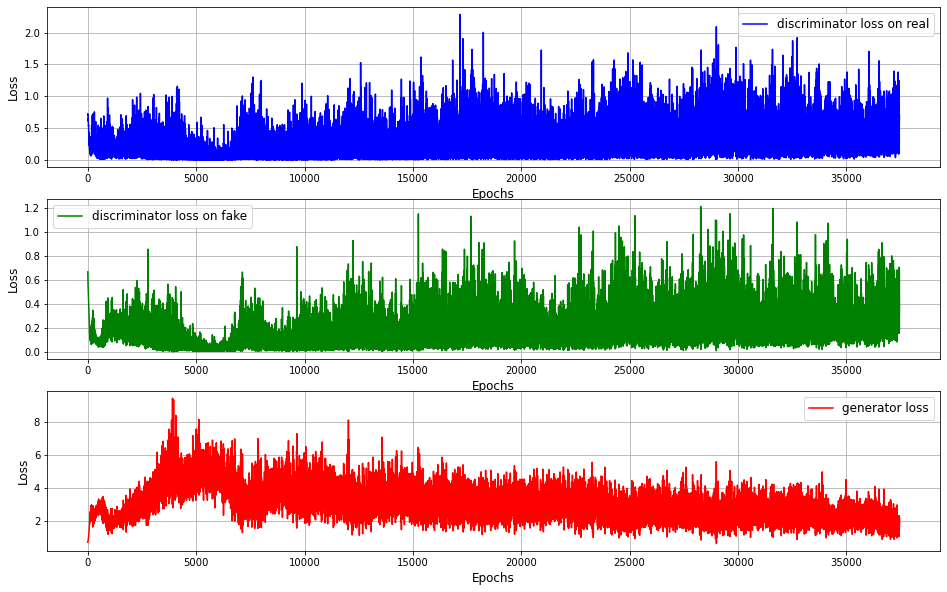

In [18]:
train_1(discriminator, generator, dataloader, config)

In [19]:
def make_samples(generator):
    noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
    noise.data.normal_(0, 1)
    fake = generator(noise)
    plt.figure(figsize=(8, 9))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(fake[i].detach().cpu().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
        plt.axis('off')

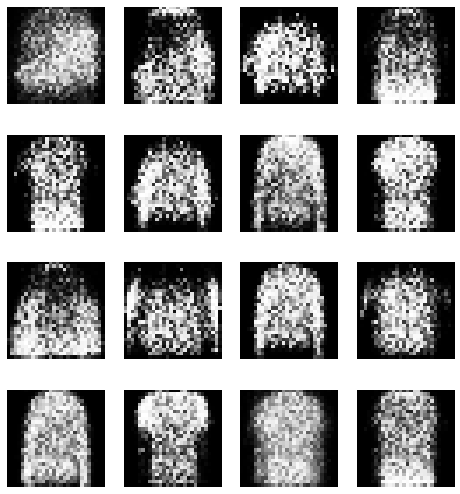

In [20]:
make_samples(generator)

# Интерполяция

In [16]:
def Interpolate(generator, num_steps = 15):
    x = np.random.randn(1, config.noise_size)
    y = np.random.randn(1, config.noise_size)
    coeffs = np.linspace(0, 1, num=num_steps)
    data = []
    for c in coeffs:
        temp = (1.0 - c) * x + c * y
        data.append(temp[0])
    steps = generator(torch.FloatTensor(data))
    plt.figure(figsize=(20, 10))
    for i, elem in enumerate(steps):
        plt.subplot(1, len(steps), 1 + i)
        plt.axis('off')
        plt.imshow(elem.detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.show()

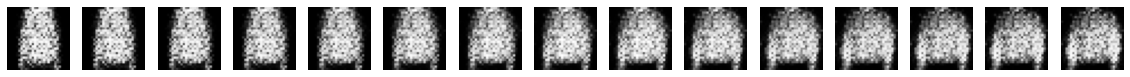

In [17]:
Interpolate(generator)

# LSGAN

In [18]:
class LSGenerator(nn.Module):
    def __init__(self):
        super(LSGenerator, self).__init__()
        self.model = nn.Sequential( 
            nn.ConvTranspose2d(50, 256, kernel_size=2, stride=2, padding=0),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 256, kernel_size=6, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 128, kernel_size=6, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = x.view(-1, 50, 1, 1)
        x = self.model(x)
        return x

class LSDiscriminator(nn.Module):
    def __init__(self):
        super(LSDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 512, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(512),
        )
        self.last_linear = nn.Sequential(nn.Linear(2*2*512, 1), nn.Sigmoid())

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = self.model(x)
        x = x.view(-1, 2*2*512)
        return self.last_linear(x)

In [19]:
def train_2(discriminator, generator, dataloader, config):
    batch = Variable(torch.FloatTensor(config.batch_size, 28*28))
    noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
    fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
    label = Variable(torch.FloatTensor(config.batch_size))
    real_label = 1
    fake_label = 0
    optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
    optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)
    criterion = nn.MSELoss()
    ERRD_x = np.zeros(config.num_epochs)
    ERRD_z = np.zeros(config.num_epochs)
    ERRG = np.zeros(config.num_epochs)
    log_ERRD_x = []
    log_ERRD_z = []
    log_ERRG = []
    N = len(dataloader)
    for epoch in range(config.num_epochs):
        for iteration, (images, cat) in enumerate(dataloader):
        ####### 
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z))) 
        #######
            discriminator.zero_grad()
        
        # real
            label.data.fill_(real_label)
            input_data = images.view(images.shape[0], -1)
            output = discriminator(input_data)
            errD_x = criterion(output, label.view(images.shape[0],1))
            ERRD_x[epoch] += errD_x.item()
            log_ERRD_x.append(errD_x.item())
            errD_x.backward()
        
        # fake 
            noise.data.normal_(0, 1)
            fake = generator(noise)
            label.data.fill_(fake_label)
            output = discriminator(fake.detach())
            errD_z = criterion(output, label.view(images.shape[0],1))
            ERRD_z[epoch] += errD_z.item()
            log_ERRD_z.append(errD_z.item())
            errD_z.backward()
        
            optim_D.step()
        
        ####### 
        # Generator stage: maximize log(D(G(x))
        #######
            generator.zero_grad()
            label.data.fill_(real_label)
            output = discriminator(fake)
            errG = criterion(output, label.view(images.shape[0],1))
            ERRG[epoch] += errG.item()
            log_ERRG.append(errG.item())
            errG.backward()
        
            optim_G.step()
            helper = True
            if (iteration+1) % config.print_freq == 0:
                clear_output(True)
                sys.stdout.write('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                                iteration+1, 
                                                                                                errD_x.item(),
                                                                                                errD_z.item(), 
                                                                                                errG.item()))
                plt.figure(figsize=(16, 10))
                plt.subplot(3, 1, 1)
                plt.plot(log_ERRD_x, color = 'blue', label = 'discriminator loss on real')
                plt.xlabel('Epochs', fontsize=12)
                plt.ylabel('Loss', fontsize=12)
                plt.legend(loc=0, fontsize=12)
                plt.grid()
                plt.subplot(3, 1, 2)
                plt.plot(log_ERRD_z, color = 'green', label = 'discriminator loss on fake')
                plt.xlabel('Epochs', fontsize=12)
                plt.ylabel('Loss', fontsize=12)
                plt.legend(loc=0, fontsize=12)
                plt.grid()
                plt.subplot(3, 1, 3)
                plt.plot(log_ERRG, color = 'red', label = 'generator loss')
                plt.xlabel('Epochs', fontsize=12)
                plt.ylabel('Loss', fontsize=12)
                plt.legend(loc=0, fontsize=12)
                plt.grid()
                plt.show()

Epoch:10 Iter: 3700 errD_x: 0.01 errD_z: 0.00 errG: 0.97

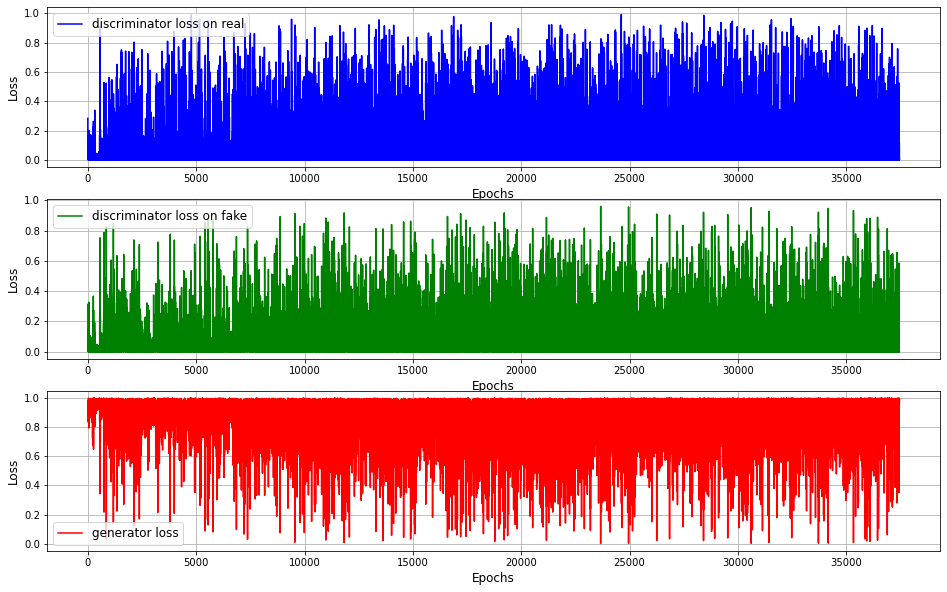

In [20]:
discriminatorLS =  LSDiscriminator()
generatorLS = LSGenerator()
train_2(discriminatorLS, generatorLS, dataloader, config)

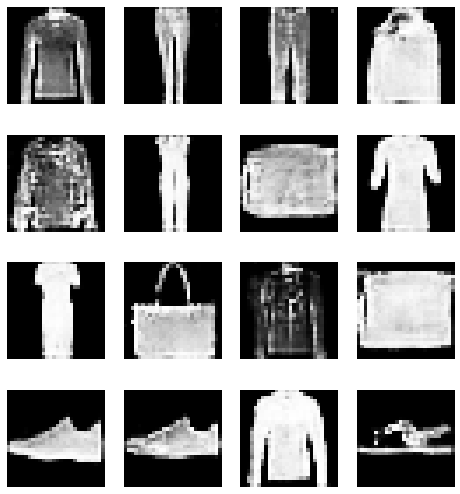

In [21]:
make_samples(generatorLS)

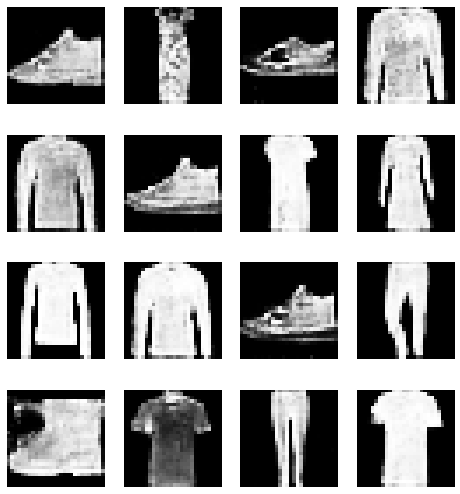

In [22]:
make_samples(generatorLS)

# Условная генерация

In [23]:
mnist_classes = 10

class Generator_cond(nn.Module):
    def __init__(self):
        super(Generator_cond, self).__init__()
        self.embeddings = nn.Embedding(mnist_classes, mnist_classes)
        self.model = nn.Sequential( 
            nn.Linear(config.noise_size+mnist_classes, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())

    def forward(self, x, labels):
        return self.model(torch.cat([x, self.embeddings(labels)], 1)).squeeze()
    
class Discriminator_cond(nn.Module):
    def __init__(self):
        super(Discriminator_cond, self).__init__()
        self.embeddings = nn.Embedding(mnist_classes, mnist_classes)
        self.model = nn.Sequential(
            nn.Linear(28*28 + mnist_classes, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1), 
            nn.Sigmoid())
    
    def forward(self, x, labels):
        return self.model(torch.cat([x, self.embeddings(labels)], 1))

In [24]:
def train_3(discriminator, generator, dataloader, config):
    batch = Variable(torch.FloatTensor(config.batch_size, 28*28))
    noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
    fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
    label = Variable(torch.FloatTensor(config.batch_size))
    real_label = 1
    fake_label = 0
    optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
    optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)
    criterion = nn.BCELoss()
    ERRD_x = np.zeros(config.num_epochs)
    ERRD_z = np.zeros(config.num_epochs)
    ERRG = np.zeros(config.num_epochs)
    log_ERRD_x = []
    log_ERRD_z = []
    log_ERRG = []
    for epoch in range(config.num_epochs):
        for iteration, (images, cat) in enumerate(dataloader):
        ####### 
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z))) 
        #######
            discriminator.zero_grad()
        
        # real
            label.data.fill_(real_label)
            input_data = images.view(images.shape[0], -1)
            output = discriminator(input_data, cat)
            errD_x = criterion(output, label.view(images.shape[0],1))
            ERRD_x[epoch] += errD_x.item()
            log_ERRD_x.append(errD_x.item())
            errD_x.backward()
        
        # fake
            fakes_wanted = torch.LongTensor(np.random.randint(0, 10, config.batch_size))
            noise.data.normal_(0, 1)
            fake = generator(noise, fakes_wanted)
            label.data.fill_(fake_label)
            output = discriminator(fake.detach(), fakes_wanted)
            errD_z = criterion(output, label.view(images.shape[0],1))
            ERRD_z[epoch] += errD_z.item()
            log_ERRD_z.append(errD_z.item())
            errD_z.backward()
        
            optim_D.step()
        
        ####### 
        # Generator stage: maximize log(D(G(x))
        #######
            generator.zero_grad()
            label.data.fill_(real_label)
            output = discriminator(fake, fakes_wanted)
            errG = criterion(output, label.view(images.shape[0],1))
            ERRG[epoch] += errG.item()
            log_ERRG.append(errG.item())
            errG.backward()
        
            optim_G.step()
            helper = True
            if (iteration+1) % config.print_freq == 0:
                clear_output(True)
                sys.stdout.write('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                                iteration+1, 
                                                                                                errD_x.item(),
                                                                                                errD_z.item(), 
                                                                                                errG.item()))
                plt.figure(figsize=(16, 10))
                plt.subplot(3, 1, 1)
                plt.plot(log_ERRD_x, color = 'blue', label = 'discriminator loss on real')
                plt.xlabel('Epochs', fontsize=12)
                plt.ylabel('Loss', fontsize=12)
                plt.legend(loc=0, fontsize=12)
                plt.grid()
                plt.subplot(3, 1, 2)
                plt.plot(log_ERRD_z, color = 'green', label = 'discriminator loss on fake')
                plt.xlabel('Epochs', fontsize=12)
                plt.ylabel('Loss', fontsize=12)
                plt.legend(loc=0, fontsize=12)
                plt.grid()
                plt.subplot(3, 1, 3)
                plt.plot(log_ERRG, color = 'red', label = 'generator loss')
                plt.xlabel('Epochs', fontsize=12)
                plt.ylabel('Loss', fontsize=12)
                plt.legend(loc=0, fontsize=12)
                plt.grid()
                plt.show()

Epoch:10 Iter: 3700 errD_x: 0.26 errD_z: 0.19 errG: 2.64

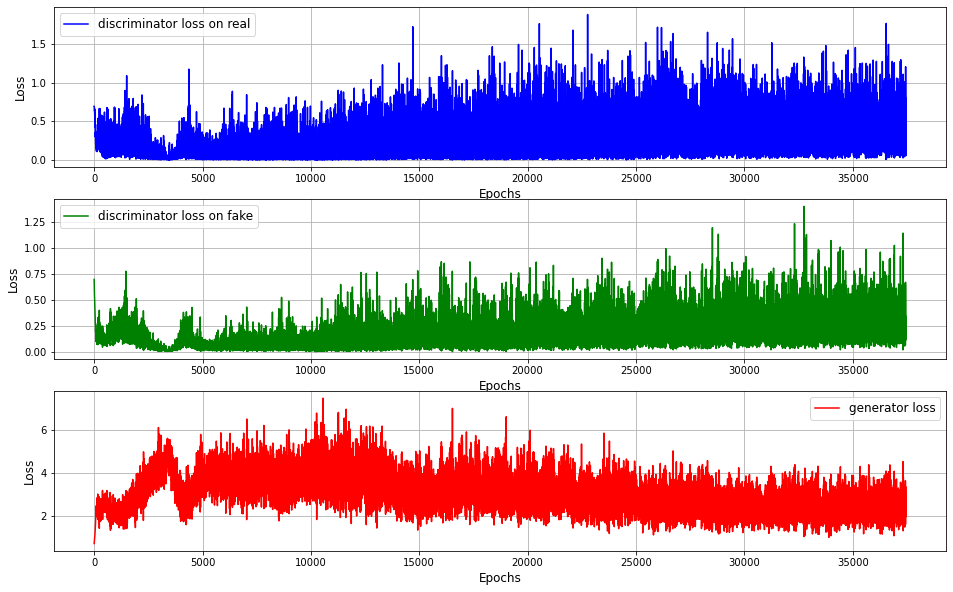

In [25]:
generator = Generator_cond()
discriminator = Discriminator_cond()
train_3(discriminator, generator, dataloader, config)

In [41]:
def make_samples(generator, faketype=8):
    noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
    noise.data.normal_(0, 1)
    fakes_wanted = Variable(torch.LongTensor(np.array([faketype for i in range(16)])))
    fake = generator(noise, fakes_wanted)
    plt.figure(figsize=(8, 9))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.title(faketype)
        plt.imshow(fake[i].detach().cpu().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
        plt.axis('off')

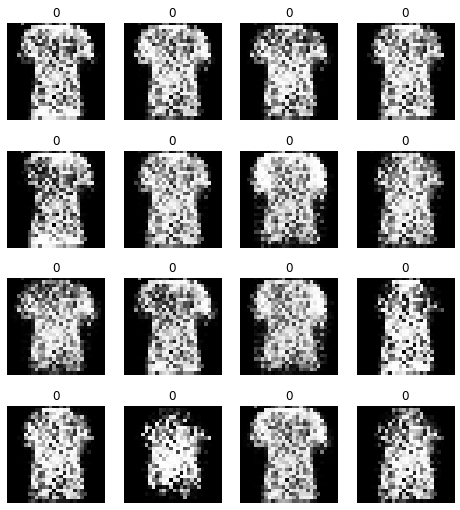

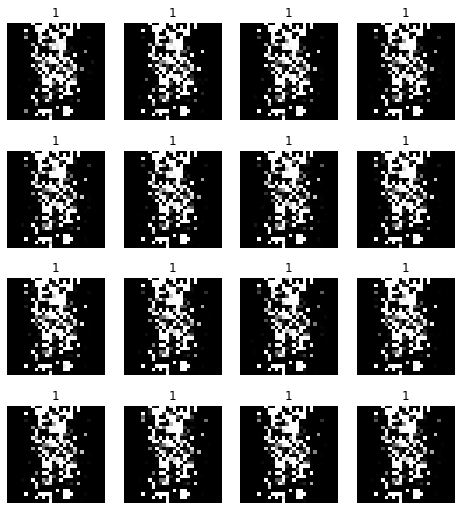

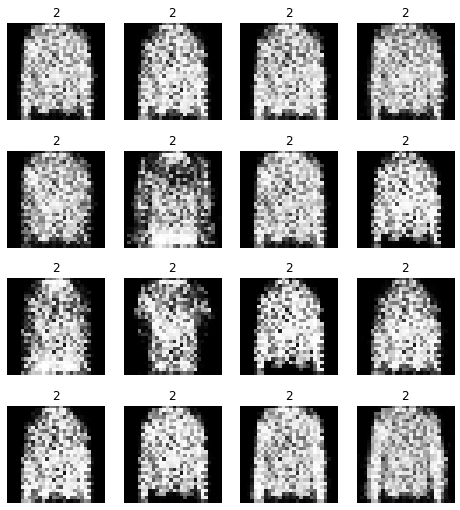

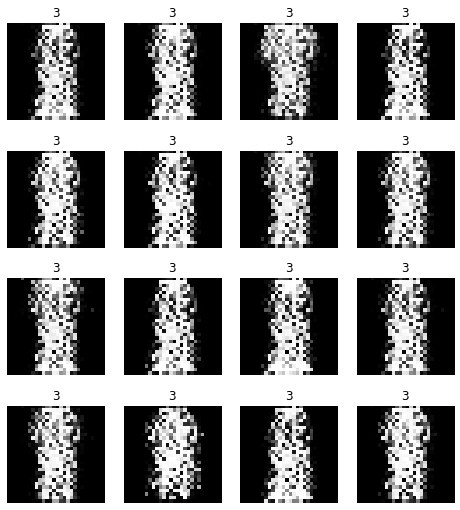

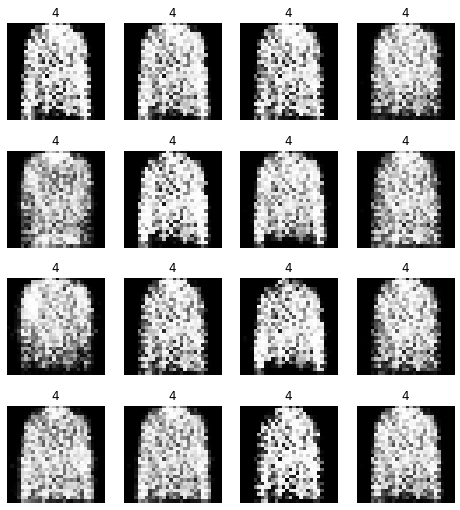

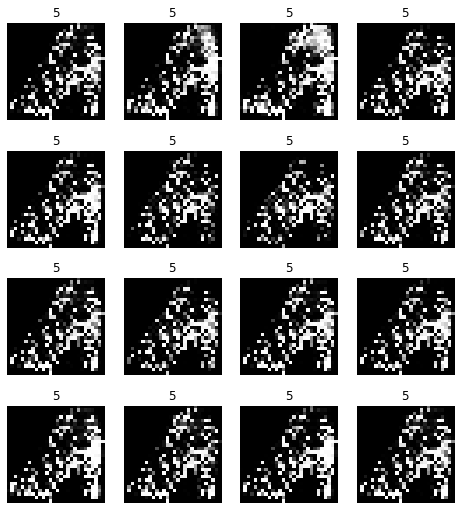

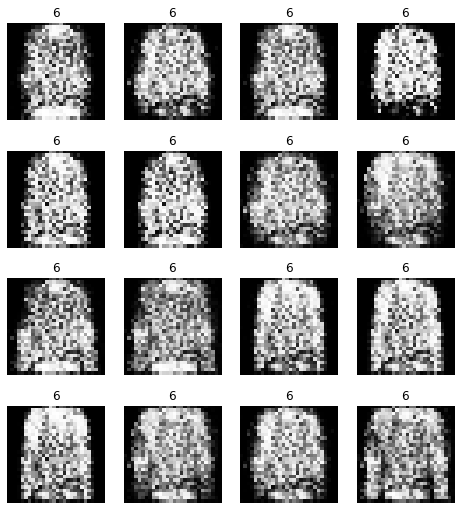

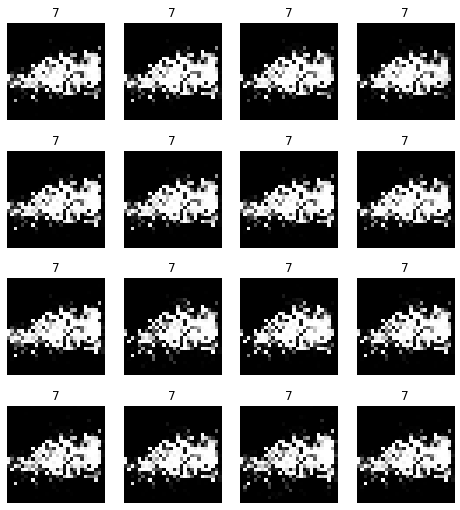

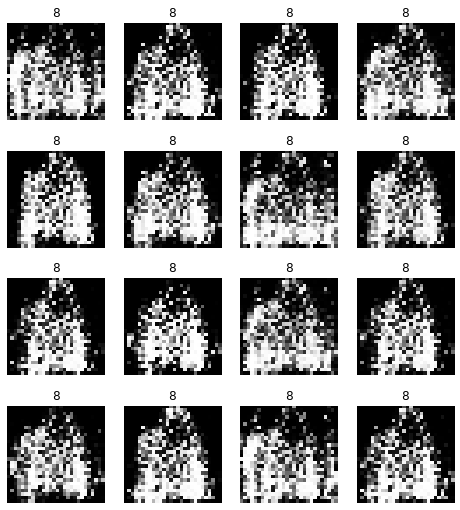

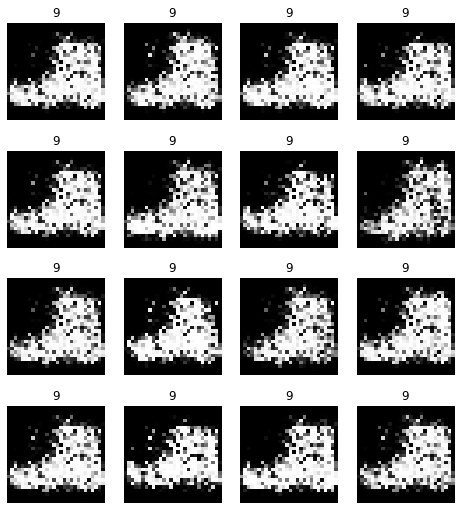

In [43]:
for i in range(0, 10):
    make_samples(generator, i)

# Выводы:

1. Сверточные ганы обучаются гораздо дольше обычных
2. При этом результаты LSGAN превосходят результаты обычных GAN-ов по качеству (артефактов в разы меньше)
3. Видимо, для повышения качества необходимо добавлять свертки в GAN-ы, возможно - дольше обучать